# Projet ML - Prédiction d'une souscription bancaire

## 1. Contexte

Une banque portugaise mène des campagnes de télémarketing pour vendre des dépôts à terme. L'objectif de ce projet est de prédire quels clients vont souscrire, afin de cibler les appels et optimiser les ressources de la campagne.

## 2. Type de problème

La variable cible est binaire (oui/non), ce qui en fait un problème de classification binaire. Nous utiliserons des algorithmes de classification pour prédire l'appartenance à une classe, tout en exploitant les probabilités prédites pour ajuster le seuil de décision.

## 3. Variables du dataset

La variable cible `y` indique si le client a souscrit au dépôt à terme. Les 15 features sont organisées en trois groupes. Les données client comprennent l'âge, la profession, le statut marital, le niveau d'éducation, le défaut de paiement, le solde bancaire, et la présence de crédits immobilier ou personnel. Les informations sur le dernier contact incluent le type de contact, le jour et le mois. Enfin, l'historique des campagnes regroupe le nombre de contacts durant la campagne, le nombre de jours depuis le dernier contact, le nombre de contacts précédents et le résultat de la campagne précédente.

Nous avons exclu la variable `duration` car elle représente la durée de l'appel, information disponible uniquement après le contact. La conserver constituerait une fuite de données.

## 4. Déséquilibre des classes

Le dataset présente un déséquilibre marqué avec 88% de refus contre 12% de souscriptions. Ce ratio reflète la réalité des campagnes marketing où les conversions restent rares. Nous devrons adapter notre approche en utilisant des métriques appropriées et des techniques de rééquilibrage.

## 5. Métriques d'évaluation

Nous privilégions le recall comme métrique principale car rater un client potentiel coûte plus cher qu'un appel inutile. L'AUC-ROC mesure la capacité globale de discrimination indépendamment du seuil. Le F1-score offre un équilibre entre precision et recall. Enfin, la matrice de confusion permet de visualiser la répartition des erreurs et d'ajuster le seuil selon les besoins métier.

## 6. Exploration des données

### 6.1 Chargement et aperçu

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Chargement des données
df = pd.read_csv('data/bank-full.csv', sep=';')

# Exclusion de la variable duration (fuite de données)
df = df.drop('duration', axis=1)

print(f"Dimensions du dataset : {df.shape[0]} lignes, {df.shape[1]} colonnes")
print(f"\nDistribution de la cible :")
print(df['y'].value_counts(normalize=True).round(3))

Dimensions du dataset : 45211 lignes, 16 colonnes

Distribution de la cible :
y
no     0.883
yes    0.117
Name: proportion, dtype: float64


In [95]:
# Types des variables et valeurs non nulles
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  y          45211 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


In [96]:
# Statistiques descriptives des variables numériques
df.describe()

,age,balance,day,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,63.000000,871.000000,275.000000


In [97]:
# Aperçu des premières lignes
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,1,-1,0,unknown,no


### 6.2 Valeurs inconnues

Le dataset contient des valeurs "unknown" dans certaines variables. Nous analysons leur distribution et leur impact sur la variable cible pour déterminer s'il s'agit de données manquantes ou d'un signal informatif.

In [98]:
# Variables contenant des valeurs "unknown"
unknown_vars = ['job', 'education', 'contact', 'poutcome']

# Comptage des "unknown" par variable
unknown_counts = pd.DataFrame({
    'Variable': unknown_vars,
    'Nb unknown': [df[var].eq('unknown').sum() for var in unknown_vars],
    '% unknown': [(df[var].eq('unknown').sum() / len(df) * 100).round(2) for var in unknown_vars]
})

print("Distribution des valeurs 'unknown' :")
print(unknown_counts.to_string(index=False))
print(f"\nTotal observations : {len(df)}")

Distribution des valeurs 'unknown' :
 Variable  Nb unknown  % unknown
      job         288       0.64
education        1857       4.11
  contact       13020      28.80
 poutcome       36959      81.75

Total observations : 45211


In [99]:
# Taux de souscription pour "unknown" vs autres valeurs
print("Taux de souscription (y='yes') pour 'unknown' vs autres valeurs :\n")

for var in unknown_vars:
    unknown_rate = df[df[var] == 'unknown']['y'].eq('yes').mean() * 100
    other_rate = df[df[var] != 'unknown']['y'].eq('yes').mean() * 100
    print(f"{var}:")
    print(f"  - unknown : {unknown_rate:.2f}%")
    print(f"  - autres  : {other_rate:.2f}%")
    print()

Taux de souscription (y='yes') pour 'unknown' vs autres valeurs :

job:
  - unknown : 11.81%
  - autres  : 11.70%

education:
  - unknown : 13.57%
  - autres  : 11.62%

contact:
  - unknown : 4.07%
  - autres  : 14.78%

poutcome:
  - unknown : 9.16%
  - autres  : 23.06%



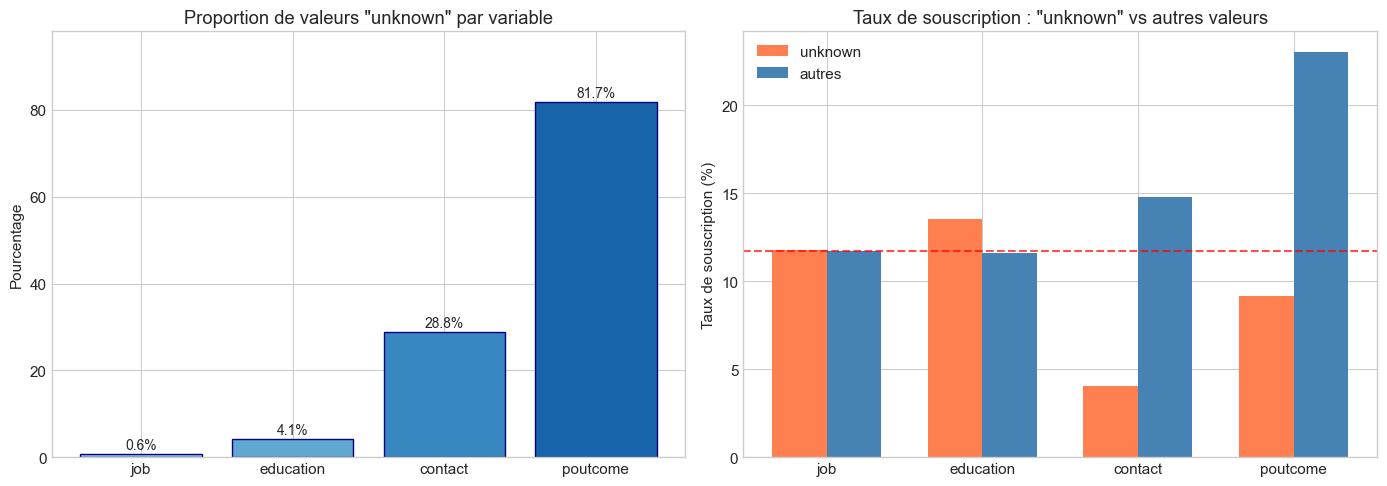

In [100]:
# Visualisation : proportion de "unknown" et taux de souscription
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 : Proportion de "unknown" par variable
unknown_pcts = [df[var].eq('unknown').mean() * 100 for var in unknown_vars]
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(unknown_vars)))
bars = axes[0].bar(unknown_vars, unknown_pcts, color=colors, edgecolor='navy')
axes[0].set_ylabel('Pourcentage')
axes[0].set_title('Proportion de valeurs "unknown" par variable')
axes[0].set_ylim(0, max(unknown_pcts) * 1.2)
for bar, pct in zip(bars, unknown_pcts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

# Graphique 2 : Taux de souscription unknown vs autres
x = np.arange(len(unknown_vars))
width = 0.35
unknown_rates = [df[df[var] == 'unknown']['y'].eq('yes').mean() * 100 for var in unknown_vars]
other_rates = [df[df[var] != 'unknown']['y'].eq('yes').mean() * 100 for var in unknown_vars]

bars1 = axes[1].bar(x - width/2, unknown_rates, width, label='unknown', color='coral')
bars2 = axes[1].bar(x + width/2, other_rates, width, label='autres', color='steelblue')
axes[1].set_ylabel('Taux de souscription (%)')
axes[1].set_title('Taux de souscription : "unknown" vs autres valeurs')
axes[1].set_xticks(x)
axes[1].set_xticklabels(unknown_vars)
axes[1].legend()
axes[1].axhline(y=df['y'].eq('yes').mean() * 100, color='red', linestyle='--', 
                label='Taux global', alpha=0.7)

plt.tight_layout()
plt.show()

### 6.3 Variables numériques

Nous analysons la distribution des variables numériques et leur relation avec la variable cible.

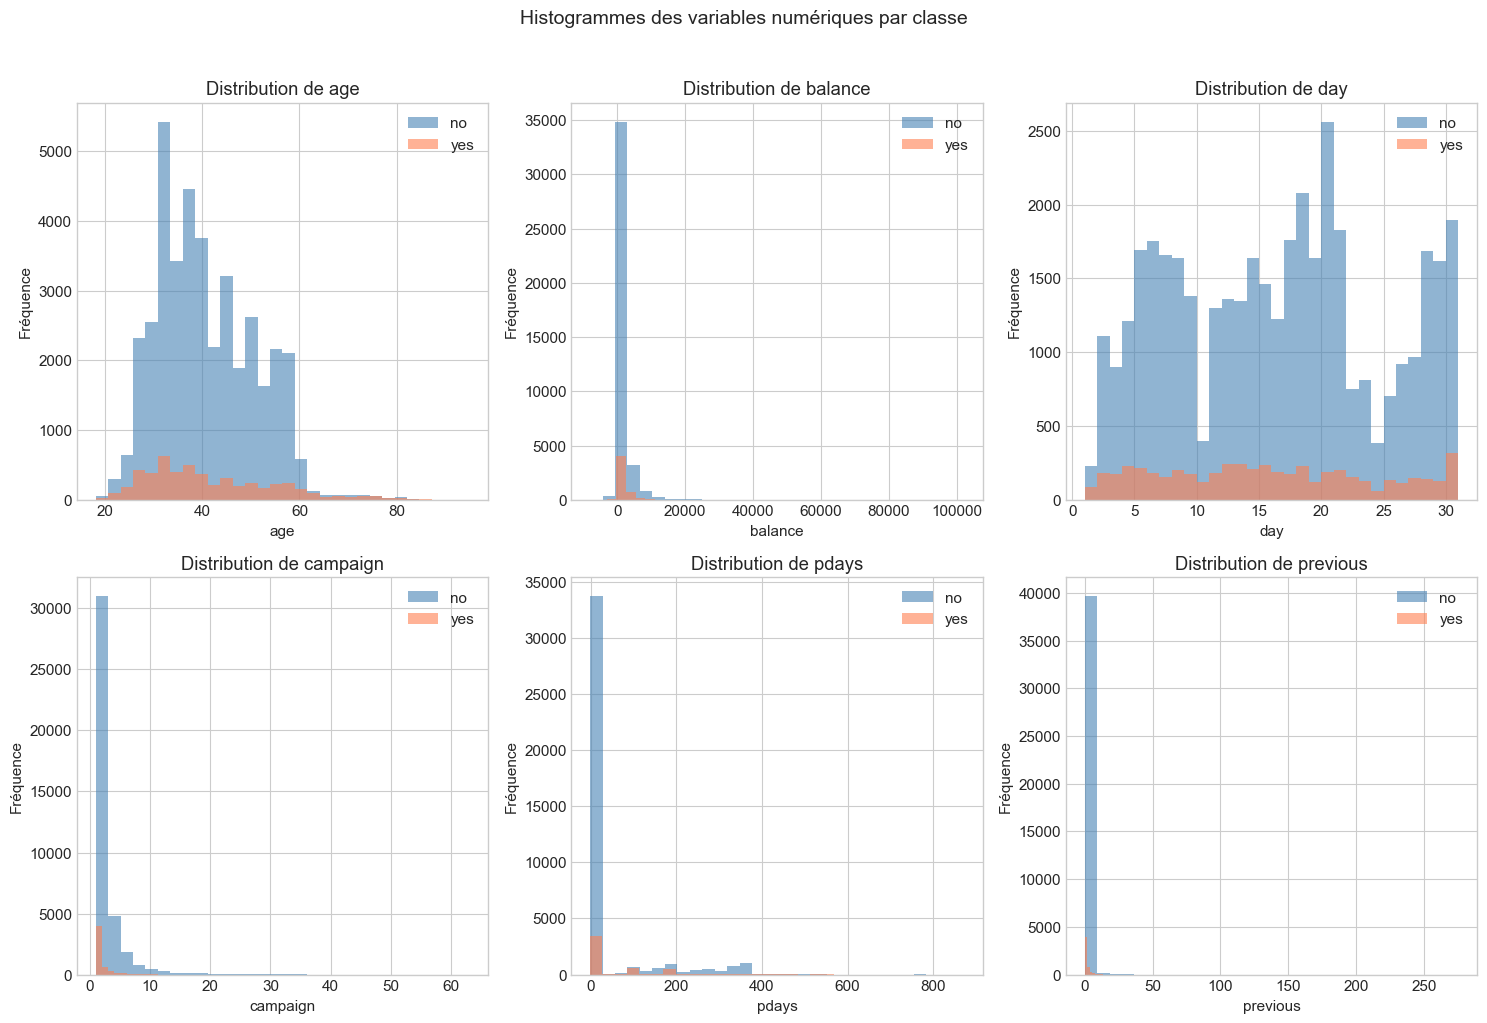

In [101]:
# Variables numériques à analyser
num_vars = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

# Histogrammes des distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(num_vars):
    ax = axes[i]
    
    # Histogramme avec séparation par classe
    df[df['y'] == 'no'][var].hist(ax=ax, bins=30, alpha=0.6, label='no', color='steelblue')
    df[df['y'] == 'yes'][var].hist(ax=ax, bins=30, alpha=0.6, label='yes', color='coral')
    
    ax.set_xlabel(var)
    ax.set_ylabel('Fréquence')
    ax.set_title(f'Distribution de {var}')
    ax.legend()

plt.suptitle('Histogrammes des variables numériques par classe', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

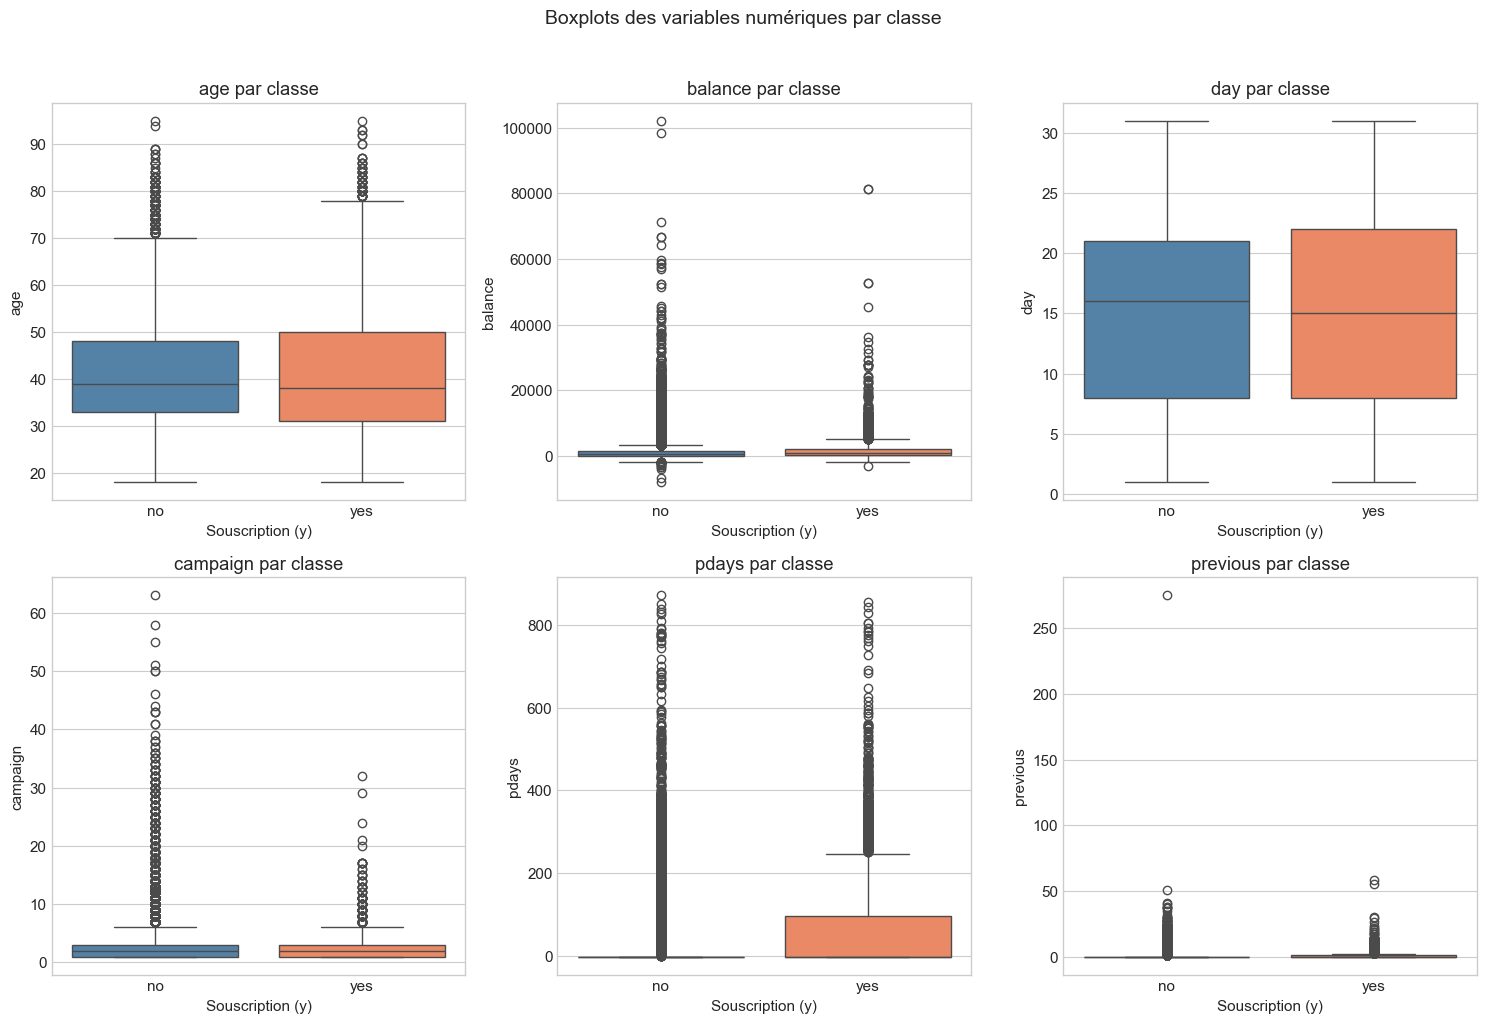

In [102]:
# Boxplots par rapport à la cible
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(num_vars):
    ax = axes[i]
    sns.boxplot(x='y', y=var, data=df, ax=ax, palette=['steelblue', 'coral'], hue='y')
    ax.set_xlabel('Souscription (y)')
    ax.set_ylabel(var)
    ax.set_title(f'{var} par classe')

plt.suptitle('Boxplots des variables numériques par classe', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [103]:
# Statistiques descriptives par classe
print("Statistiques descriptives par classe :\n")
print(df.groupby('y')[num_vars].agg(['mean', 'median', 'std']).round(2))

Statistiques descriptives par classe :

       age                balance                   day              campaign  \
      mean median    std     mean median     std   mean median   std     mean   
y                                                                               
no   40.84   39.0  10.17  1303.71  417.0  2974.2  15.89   16.0  8.29     2.85   
yes  41.67   38.0  13.50  1804.27  733.0  3501.1  15.16   15.0  8.50     2.14   

                  pdays                previous               
    median   std   mean median     std     mean median   std  
y                                                             
no     2.0  3.21  36.42   -1.0   96.76     0.50    0.0  2.26  
yes    2.0  1.92  68.70   -1.0  118.82     1.17    0.0  2.55  


### 6.4 Variables catégorielles

Nous analysons les fréquences des variables catégorielles et leur relation avec le taux de souscription.

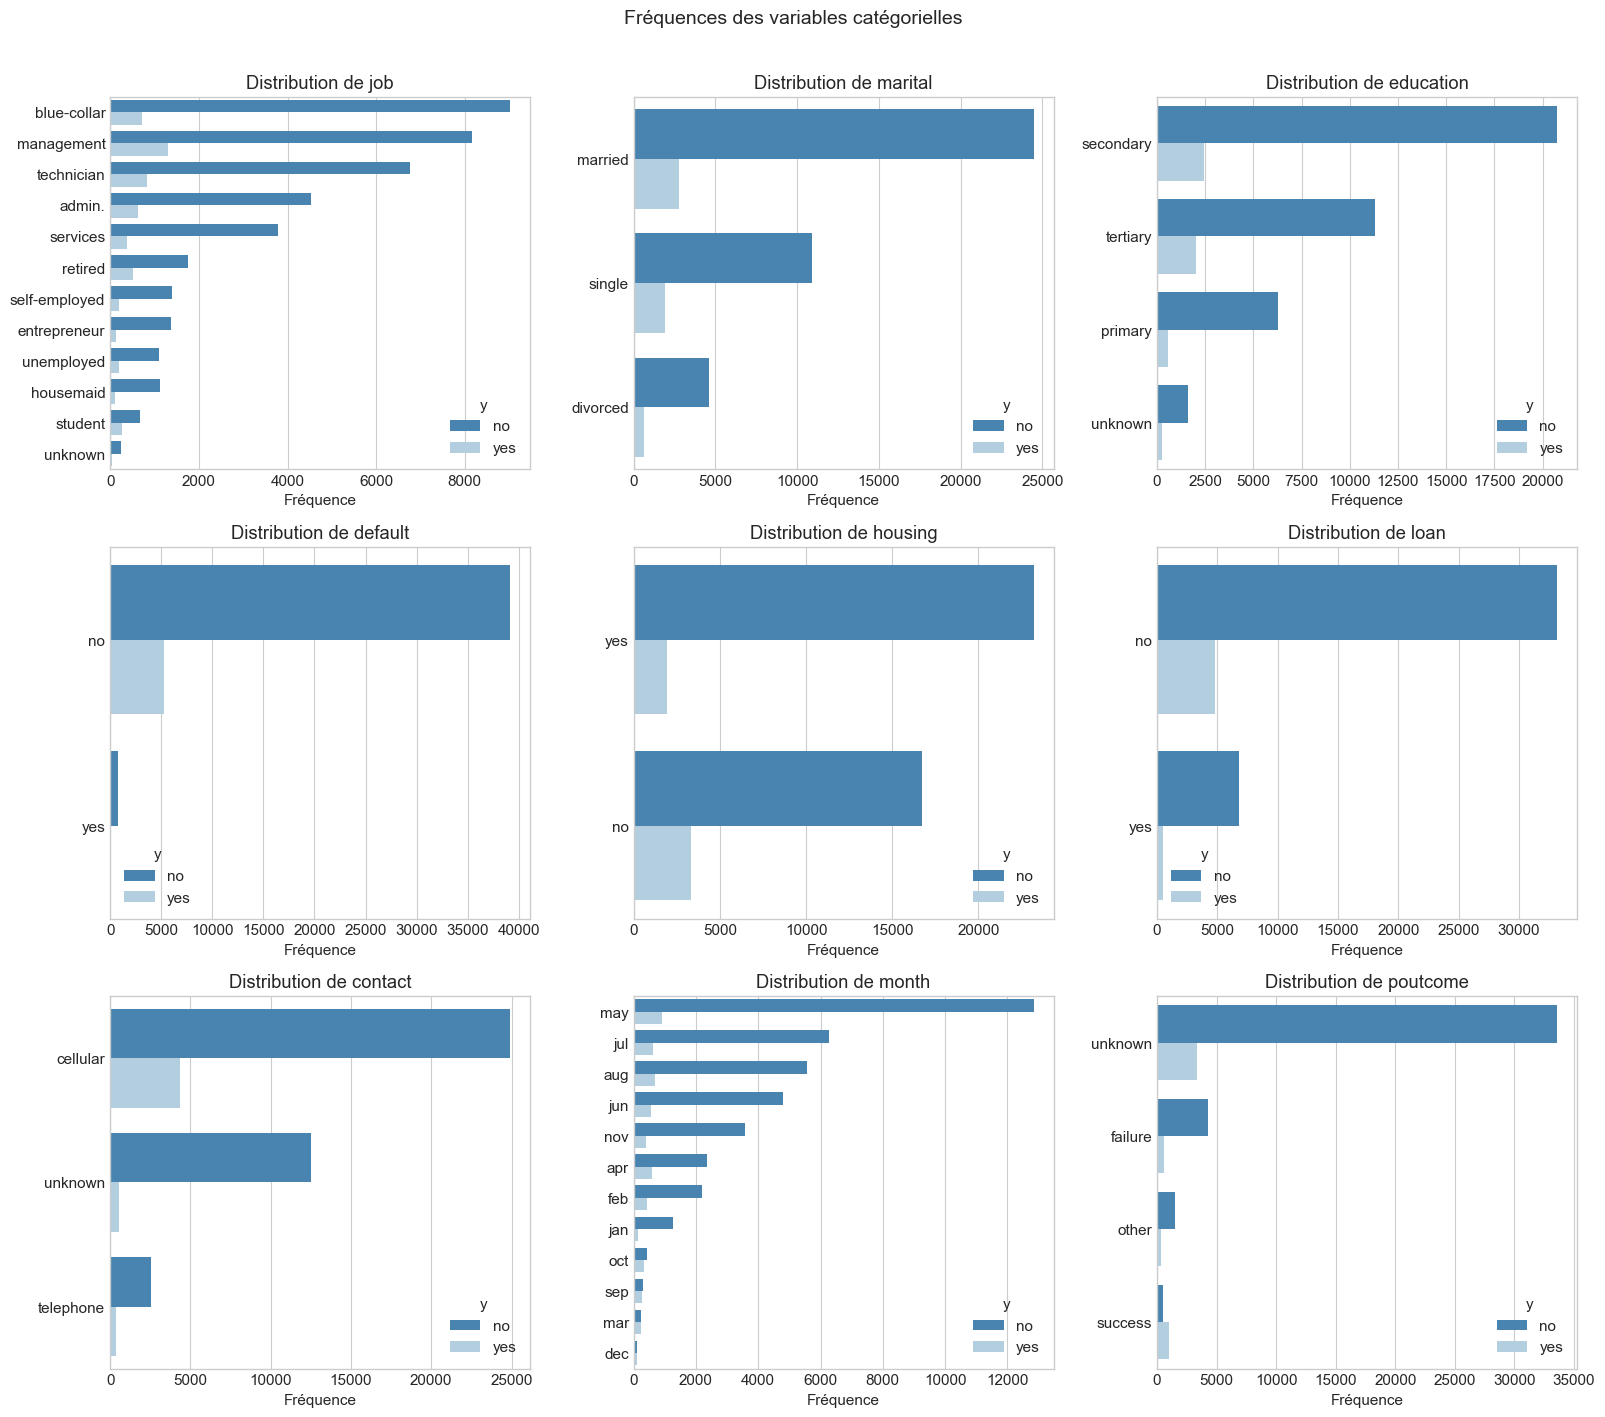

In [104]:
# Variables catégorielles
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Barplots des fréquences
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

for i, var in enumerate(cat_vars):
    ax = axes[i]
    order = df[var].value_counts().index
    sns.countplot(y=var, data=df, order=order, ax=ax, palette='Blues_r', hue='y')
    ax.set_xlabel('Fréquence')
    ax.set_ylabel('')
    ax.set_title(f'Distribution de {var}')

plt.suptitle('Fréquences des variables catégorielles', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

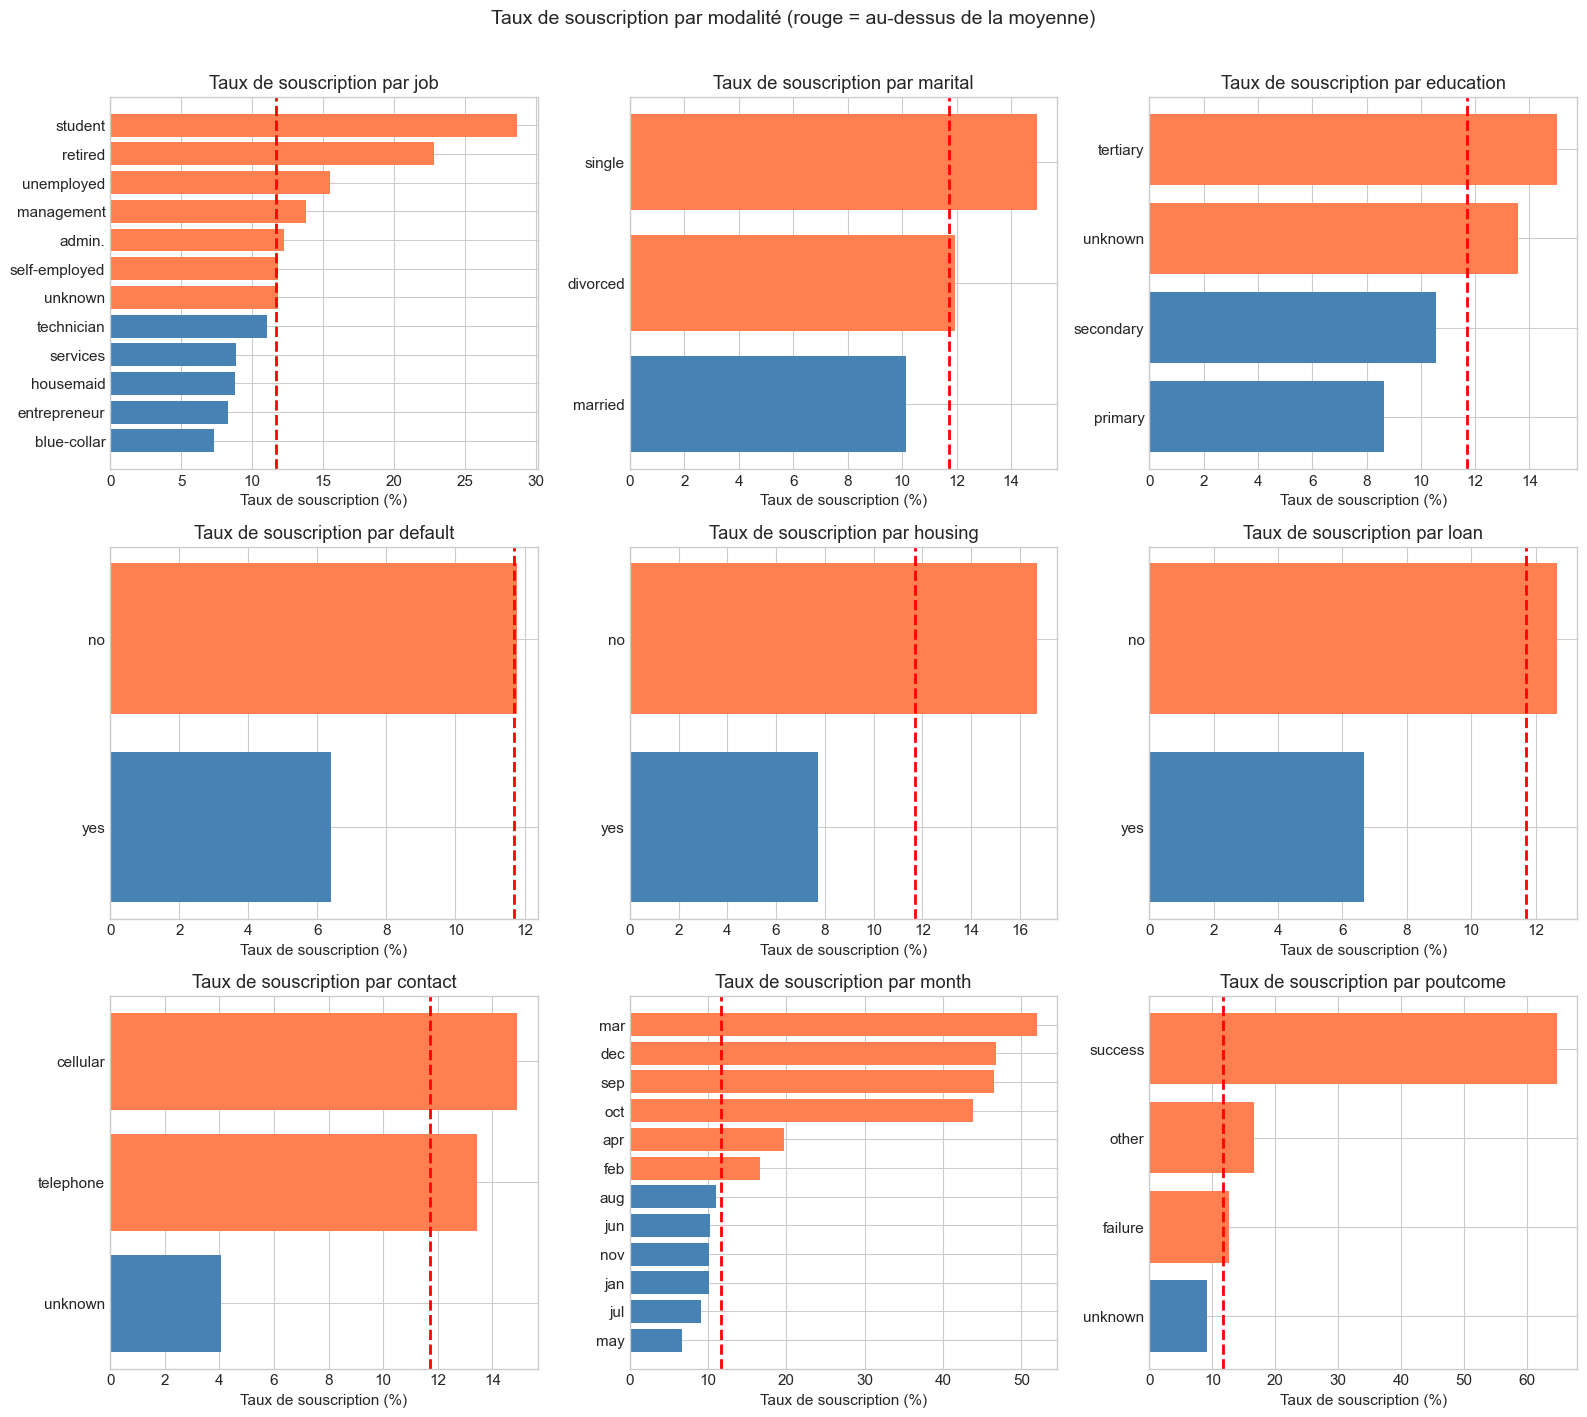

In [105]:
# Taux de souscription par modalité (analyse bivariée)
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

global_rate = df['y'].eq('yes').mean() * 100

for i, var in enumerate(cat_vars):
    ax = axes[i]
    
    # Calculer le taux de souscription par modalité
    rates = df.groupby(var)['y'].apply(lambda x: (x == 'yes').mean() * 100)
    rates = rates.sort_values(ascending=True)
    
    # Couleur selon si au-dessus ou en-dessous du taux global
    colors = ['coral' if r > global_rate else 'steelblue' for r in rates]
    
    bars = ax.barh(rates.index, rates.values, color=colors)
    ax.axvline(x=global_rate, color='red', linestyle='--', linewidth=2, label=f'Taux global ({global_rate:.1f}%)')
    ax.set_xlabel('Taux de souscription (%)')
    ax.set_ylabel('')
    ax.set_title(f'Taux de souscription par {var}')

plt.suptitle('Taux de souscription par modalité (rouge = au-dessus de la moyenne)', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

### 6.5 Corrélations

Nous analysons les corrélations entre les variables numériques et avec la variable cible.

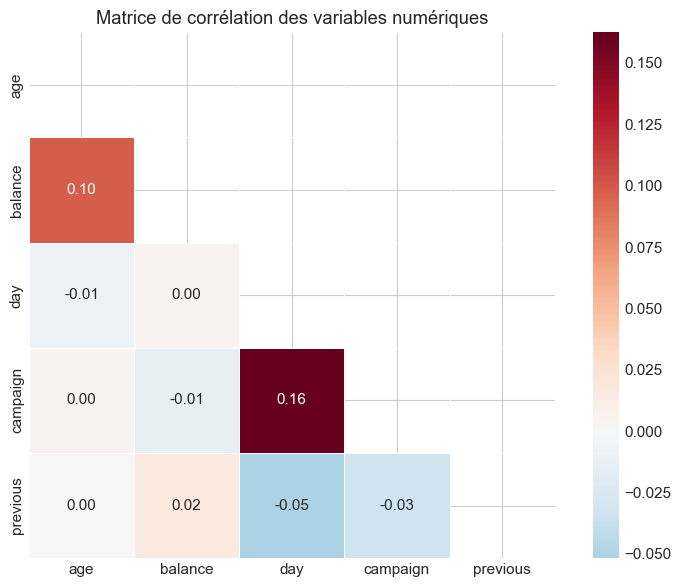


Corrélation pdays-previous (tous clients, n=45211) : r = 0.455
Corrélation pdays-previous (clients déjà contactés, n=8257) : r = -0.022


In [106]:
# Matrice de corrélation des variables numériques
# Note : pdays exclu car -1 = "jamais contacté" (valeur catégorielle, pas numérique)
# Pour pdays, on analysera séparément la corrélation avec la cible
num_cols = ['age', 'balance', 'day', 'campaign', 'previous']
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Matrice de corrélation des variables numériques')
plt.tight_layout()
plt.show()

# Corrélation pdays-previous (tous les clients)
corr_pdays_prev_all = df['pdays'].corr(df['previous'])
print(f"\nCorrélation pdays-previous (tous clients, n={len(df)}) : r = {corr_pdays_prev_all:.3f}")

# Vérification : corrélation pdays-previous sur clients déjà contactés uniquement
df_contacted = df[df['pdays'] > 0]
corr_pdays_prev_contacted = df_contacted['pdays'].corr(df_contacted['previous'])
print(f"Corrélation pdays-previous (clients déjà contactés, n={len(df_contacted)}) : r = {corr_pdays_prev_contacted:.3f}")

Corrélation point-biserial avec la cible (y) :

age          : r = +0.0252 ***
balance      : r = +0.0528 ***
day          : r = -0.0283 ***
campaign     : r = -0.0732 ***
previous     : r = +0.0932 ***
pdays        : r = +0.1036 *** (note: -1 = jamais contacté)

* p < 0.05, ** p < 0.01, *** p < 0.001


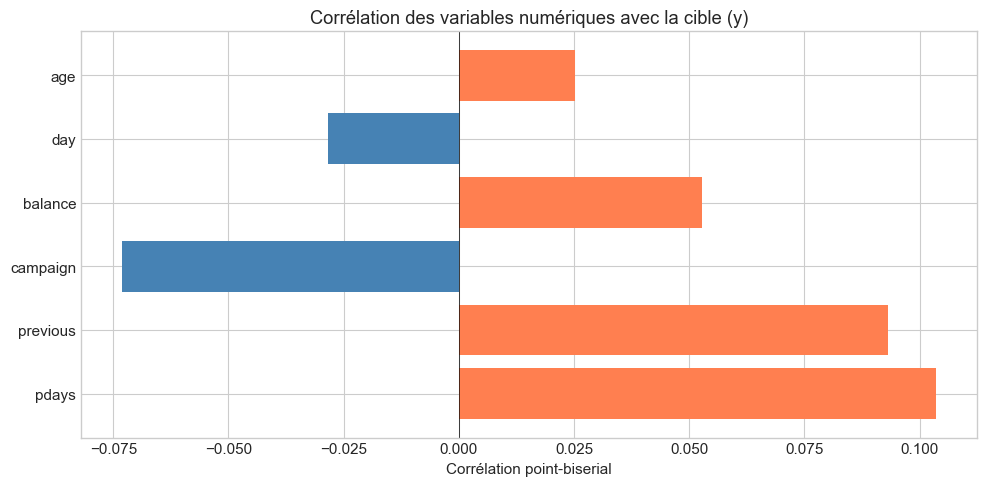

In [107]:
# Point-biserial correlation avec la cible
# Convertir y en binaire
y_binary = (df['y'] == 'yes').astype(int)

# Calculer les corrélations point-biserial pour les variables numériques continues
print("Corrélation point-biserial avec la cible (y) :\n")
pb_correlations = {}
for var in num_cols:
    corr, pvalue = stats.pointbiserialr(y_binary, df[var])
    pb_correlations[var] = corr
    significance = "***" if pvalue < 0.001 else "**" if pvalue < 0.01 else "*" if pvalue < 0.05 else ""
    print(f"{var:12} : r = {corr:+.4f} {significance}")

# Corrélation pour pdays (variable mixte : -1 = jamais contacté, sinon nombre de jours)
# On calcule la corrélation point-biserial même si la distribution est particulière
corr_pdays, pvalue_pdays = stats.pointbiserialr(y_binary, df['pdays'])
pb_correlations['pdays'] = corr_pdays
significance_pdays = "***" if pvalue_pdays < 0.001 else "**" if pvalue_pdays < 0.01 else "*" if pvalue_pdays < 0.05 else ""
print(f"{'pdays':12} : r = {corr_pdays:+.4f} {significance_pdays} (note: -1 = jamais contacté)")

print("\n* p < 0.05, ** p < 0.01, *** p < 0.001")

# Visualisation
plt.figure(figsize=(10, 5))
sorted_corr = dict(sorted(pb_correlations.items(), key=lambda x: abs(x[1]), reverse=True))
colors = ['coral' if v > 0 else 'steelblue' for v in sorted_corr.values()]
bars = plt.barh(list(sorted_corr.keys()), list(sorted_corr.values()), color=colors)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.xlabel('Corrélation point-biserial')
plt.title('Corrélation des variables numériques avec la cible (y)')
plt.tight_layout()
plt.show()

### 6.6 Synthèse de l'exploration

L'analyse exploratoire révèle plusieurs éléments clés pour la modélisation.

**Déséquilibre des classes.** Le dataset compte 88% de refus contre 12% de souscriptions. Cette proportion importante nécessite l'utilisation de techniques adaptées comme le paramètre class_weight ou l'ajustement du seuil de décision.

**Variables les plus prédictives.** Le résultat de la campagne précédente (`poutcome`) est le meilleur prédicteur avec un taux de souscription de 65% pour les clients ayant déjà souscrit. Les mois de fin de trimestre (mars, juin, septembre, décembre) présentent des taux de conversion nettement supérieurs, entre 44% et 52%. Le type de contact influence également la réponse, avec 15% de conversion pour les contacts par téléphone mobile contre seulement 4% pour les contacts de type inconnu.

**Valeurs inconnues.** Les variables `contact` et `poutcome` contiennent respectivement 29% et 82% de valeurs "unknown". Nous observons que ces valeurs ne sont pas des données manquantes aléatoires mais un signal informatif. Les clients avec un contact de type inconnu souscrivent beaucoup moins (4% contre 15%), et ceux sans historique de campagne précédente (poutcome=unknown) souscrivent moins également (9% contre 23%). Nous conservons donc ces valeurs comme une modalité distincte.

**Variables numériques.** Les souscripteurs présentent un solde bancaire médian plus élevé (733€ contre 417€) et reçoivent moins d'appels durant la campagne (2.1 contre 2.9 en moyenne). La variable `pdays` contient 82% de valeurs à -1 indiquant les clients jamais contactés auparavant.



## 7. Preprocessing

### 7.1 Feature engineering

Nous créeons trois variables dérivées pour capturer les patterns identifiés. La variable `already_contacted` indiquera si le client a été contacté lors d'une campagne précédente. La variable `quarter` regroupera les mois par trimestre. Enfin, `is_end_of_quarter` marquera les mois favorables. Le solde bancaire sera transformé par une fonction logarithmique pour réduire l'asymétrie de sa distribution.

In [ ]:
# Copie du dataframe pour le preprocessing
df_prep = df.copy()

# 1. already_contacted indique si le client a été contacté lors d'une campagne précédente
df_prep['already_contacted'] = (df_prep['pdays'] > 0).astype(int)
print(f"already_contacted : {df_prep['already_contacted'].sum()} clients déjà contactés ({df_prep['already_contacted'].mean()*100:.1f}%)")

# 2. quarter regroupe les mois par trimestre
month_to_quarter = {
    'jan': 1, 'feb': 1, 'mar': 1,
    'apr': 2, 'may': 2, 'jun': 2,
    'jul': 3, 'aug': 3, 'sep': 3,
    'oct': 4, 'nov': 4, 'dec': 4
}
df_prep['quarter'] = df_prep['month'].map(month_to_quarter)
print(f"\nquarter distribution :\n{df_prep['quarter'].value_counts().sort_index()}")

# 3. is_end_of_quarter marque les mois favorables identifiés dans l'exploration
end_of_quarter_months = ['mar', 'jun', 'sep', 'dec']
df_prep['is_end_of_quarter'] = df_prep['month'].isin(end_of_quarter_months).astype(int)
print(f"\nis_end_of_quarter : {df_prep['is_end_of_quarter'].sum()} contacts en fin de trimestre ({df_prep['is_end_of_quarter'].mean()*100:.1f}%)")

In [ ]:
# Vérification de l'impact des nouvelles features sur la cible
print("Taux de souscription par nouvelle feature\n")

for feat in ['already_contacted', 'is_end_of_quarter', 'quarter']:
    print(f"--- {feat} ---")
    rates = df_prep.groupby(feat)['y'].apply(lambda x: (x == 'yes').mean() * 100)
    for val, rate in rates.items():
        count = (df_prep[feat] == val).sum()
        print(f"  {val} : {rate:.2f}% (n={count})")
    print()

### 7.2 Transformation du solde bancaire

La variable `balance` présente une distribution très asymétrique. Nous appliquons une transformation logarithmique pour la normaliser.

In [ ]:
# Transformation logarithmique du solde avec décalage pour les valeurs négatives
balance_min = df_prep['balance'].min()
df_prep['balance_log'] = np.log1p(df_prep['balance'] - balance_min)

# Visualisation avant et après transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_prep['balance'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution originale')
axes[0].set_xlabel('Balance (€)')

axes[1].hist(df_prep['balance_log'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution après transformation log')
axes[1].set_xlabel('log(balance)')

plt.tight_layout()
plt.show()

print(f"Asymétrie avant transformation : {df_prep['balance'].skew():.2f}")
print(f"Asymétrie après transformation : {df_prep['balance_log'].skew():.2f}")

### 7.3 Encodage des variables

Nous utilisons OneHotEncoder pour les variables catégorielles et définissons les colonnes numériques à conserver.

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Variables catégorielles
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Variables numériques incluant les features créées
num_cols_final = ['age', 'balance_log', 'day', 'campaign', 'previous', 
                  'already_contacted', 'quarter', 'is_end_of_quarter']

# Variables exclues car remplacées
cols_to_drop = ['balance', 'pdays']

print(f"Variables catégorielles ({len(cat_cols)})")
print(f"Variables numériques ({len(num_cols_final)})")
print(f"Variables exclues : {cols_to_drop}")

In [ ]:
# Encodage de la variable cible
label_encoder = LabelEncoder()
df_prep['y_encoded'] = label_encoder.fit_transform(df_prep['y'])
print(f"Classes : {list(label_encoder.classes_)} encodées en [0, 1]")

In [ ]:
from sklearn.model_selection import train_test_split

# Préparation des features et de la cible
X = df_prep[num_cols_final + cat_cols]
y = df_prep['y_encoded']

# Split train/test avec stratification pour conserver la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Ensemble d'entraînement : {X_train.shape[0]} observations")
print(f"Ensemble de test : {X_test.shape[0]} observations")
print(f"\nDistribution de la cible préservée")
print(f"  Train : {y_train.mean()*100:.2f}% positifs")
print(f"  Test : {y_test.mean()*100:.2f}% positifs")

### 7.4 Pipeline de prétraitement

Nous construisons un pipeline sklearn qui standardise les variables numériques et encode les variables catégorielles.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_final),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

# Application du preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Récupération des noms de colonnes pour l'interprétation
num_feature_names = num_cols_final
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
all_feature_names = num_feature_names + cat_feature_names

print(f"Dimensions après preprocessing")
print(f"  X_train : {X_train_processed.shape}")
print(f"  X_test : {X_test_processed.shape}")
print(f"\n{len(num_feature_names)} features numériques + {len(cat_feature_names)} features catégorielles encodées")

### 7.5 Gestion du déséquilibre des classes

Pour gérer le déséquilibre, nous utilisons le paramètre class_weight des modèles qui pondère les observations de la classe minoritaire. Nous préparons également un ensemble rééquilibré par SMOTE comme alternative.

In [ ]:
from imblearn.over_sampling import SMOTE

# Application de SMOTE sur les données d'entraînement
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print("Distribution avant et après SMOTE")
print(f"\nAvant : {(y_train == 0).sum()} négatifs, {(y_train == 1).sum()} positifs")
print(f"Après : {(y_train_smote == 0).sum()} négatifs, {(y_train_smote == 1).sum()} positifs")

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calcul des poids de classes pour les modèles
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Poids calculés : classe 0 = {class_weights[0]:.2f}, classe 1 = {class_weights[1]:.2f}")

### 7.6 Synthèse du preprocessing

Le preprocessing a produit trois jeux de données prêts pour la modélisation. Le jeu original prétraité sera utilisé avec les modèles supportant le paramètre class_weight. Le jeu rééquilibré par SMOTE servira de comparaison. Le jeu de test reste intact pour l'évaluation finale.

Nous avons créé trois variables dérivées. La variable `already_contacted` remplace `pdays` et indique si le client a déjà été contacté. Les variables `quarter` et `is_end_of_quarter` capturent la saisonnalité observée dans l'exploration. Le solde bancaire a été transformé par une fonction logarithmique pour normaliser sa distribution.

Les données sont maintenant prêtes pour l'entraînement des modèles.

## 8. Modélisation

### 8.1 Configuration des modèles

Nous comparons trois modèles de classification aux approches distinctes : un modèle linéaire (Logistic Regression), un ensemble par bagging (Random Forest), et un ensemble par boosting (LightGBM). Cette sélection couvre les principales familles d'algorithmes tout en restant compréhensible. L'optimisation des hyperparamètres est réalisée par GridSearchCV avec validation croisée à 5 plis, en limitant le nombre de combinaisons à moins de 100 pour un temps de calcul raisonnable.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score, 
                             confusion_matrix, classification_report, roc_curve, 
                             precision_recall_curve)
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

# Configuration de la cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Modèles à entraîner :")
print("  1. Logistic Regression (linéaire)")
print("  2. Random Forest (bagging)")
print("  3. LightGBM (boosting)")

In [ ]:
# Définition des modèles et leurs hyperparamètres
# Chaque grille est limitée à un nombre raisonnable de combinaisons (<100 au total)

models = {
    'LogisticRegression': {
        'model': LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
        # 4 × 2 = 8 combinaisons
    },
    'RandomForest': {
        'model': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5]
        }
        # 2 × 3 × 2 = 12 combinaisons
    },
    'LightGBM': {
        'model': LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [5, 10]
        }
        # 2 × 2 × 2 = 8 combinaisons
    }
}

# Calcul du nombre total de combinaisons
total_combinations = sum(
    np.prod([len(v) for v in config['params'].values()]) 
    for config in models.values()
)
print(f"Nombre de modèles : {len(models)}")
print(f"Nombre total de combinaisons : {total_combinations}")

### 8.2 Entraînement

Nous entraînons chaque modèle avec GridSearchCV pour explorer toutes les combinaisons d'hyperparamètres et identifier la meilleure configuration.

In [ ]:
%%time

# Dictionnaire pour stocker les résultats
results = {}
best_models = {}

print("=" * 60)
print("ENTRAÎNEMENT DES MODÈLES")
print("=" * 60)

for name, config in models.items():
    print(f"\n▶ {name}...")
    
    # GridSearchCV
    search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=cv,
        scoring='recall',
        n_jobs=-1,
        verbose=0
    )
    
    # Entraînement
    search.fit(X_train_processed, y_train)
    
    # Stockage du meilleur modèle
    best_models[name] = search.best_estimator_
    
    # Prédictions sur le test set
    y_pred = search.best_estimator_.predict(X_test_processed)
    y_proba = search.best_estimator_.predict_proba(X_test_processed)[:, 1]
    
    # Métriques
    results[name] = {
        'best_params': search.best_params_,
        'cv_recall': search.best_score_,
        'test_recall': recall_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_auc': roc_auc_score(y_test, y_proba),
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    
    print(f"  Meilleurs paramètres : {search.best_params_}")
    print(f"  CV Recall: {results[name]['cv_recall']:.4f}")
    print(f"  Test Recall: {results[name]['test_recall']:.4f} | AUC: {results[name]['test_auc']:.4f}")

print("\n" + "=" * 60)
print("ENTRAÎNEMENT TERMINÉ")
print("=" * 60)

### 8.3 Comparaison des performances

In [ ]:
# Tableau comparatif des performances
comparison_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'CV Recall': [results[m]['cv_recall'] for m in results],
    'Test Recall': [results[m]['test_recall'] for m in results],
    'Test Precision': [results[m]['test_precision'] for m in results],
    'Test F1': [results[m]['test_f1'] for m in results],
    'Test AUC': [results[m]['test_auc'] for m in results]
}).round(4)

# Trier par Recall (métrique principale)
comparison_df = comparison_df.sort_values('Test Recall', ascending=False)

print("COMPARAISON DES MODÈLES (trié par Recall)")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Identification du meilleur modèle
best_model_name = comparison_df.iloc[0]['Modèle']
print(f"\n★ Meilleur modèle (Recall) : {best_model_name}")
print(f"  Recall = {comparison_df.iloc[0]['Test Recall']:.4f}")
print(f"  AUC = {comparison_df.iloc[0]['Test AUC']:.4f}")

In [ ]:
# Visualisation des performances
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 : Barplot des métriques
metrics = ['Test Recall', 'Test Precision', 'Test F1', 'Test AUC']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics):
    offset = (i - 1.5) * width
    bars = axes[0].bar(x + offset, comparison_df[metric], width, label=metric)

axes[0].set_xlabel('Modèle')
axes[0].set_ylabel('Score')
axes[0].set_title('Comparaison des métriques par modèle')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Modèle'], rotation=45, ha='right')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1)

# Graphique 2 : Focus sur Recall vs Precision (trade-off)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(comparison_df)))
for i, (_, row) in enumerate(comparison_df.iterrows()):
    axes[1].scatter(row['Test Precision'], row['Test Recall'], 
                    s=200, c=[colors[i]], label=row['Modèle'], edgecolors='black')
    
axes[1].set_xlabel('Precision')
axes[1].set_ylabel('Recall')
axes[1].set_title('Trade-off Precision vs Recall')
axes[1].legend(loc='lower left', fontsize=9)
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 8.4 Courbes ROC et Precision-Recall

In [ ]:
# Courbes ROC et Precision-Recall pour tous les modèles
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

# Courbes ROC
for (name, res), color in zip(results.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    axes[0].plot(fpr, tpr, color=color, lw=2, 
                 label=f"{name} (AUC={res['test_auc']:.3f})")

axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Courbes ROC')
axes[0].legend(loc='lower right', fontsize=9)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Courbes Precision-Recall
for (name, res), color in zip(results.items(), colors):
    precision, recall, _ = precision_recall_curve(y_test, res['y_proba'])
    axes[1].plot(recall, precision, color=color, lw=2, label=name)

# Ligne de base (proportion de positifs)
baseline = y_test.mean()
axes[1].axhline(y=baseline, color='k', linestyle='--', lw=1, label=f'Baseline ({baseline:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Courbes Precision-Recall')
axes[1].legend(loc='upper right', fontsize=9)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

### 8.5 Matrices de confusion

In [ ]:
# Matrices de confusion pour tous les modèles
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    axes[i].set_xlabel('Prédit')
    axes[i].set_ylabel('Réel')
    axes[i].set_title(f'{name}\nRecall={res["test_recall"]:.3f}')

plt.suptitle('Matrices de confusion (Test Set)', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### 8.6 Analyse du meilleur modèle

In [ ]:
# Détails du meilleur modèle
best_model = best_models[best_model_name]
best_result = results[best_model_name]

print(f"MEILLEUR MODÈLE : {best_model_name}")
print("=" * 60)

print("\nHyperparamètres optimaux :")
for param, value in best_result['best_params'].items():
    print(f"  {param}: {value}")

print("\nRapport de classification détaillé :")
print(classification_report(y_test, best_result['y_pred'], target_names=['No', 'Yes']))

In [ ]:
# Feature importance (si disponible)
# Utilisation du modèle basé sur les arbres avec la meilleure AUC pour l'interprétation
tree_models = ['RandomForest', 'XGBoost', 'LightGBM', 'GradientBoosting']
best_tree_model_name = None
best_tree_auc = 0

for name in tree_models:
    if name in results and results[name]['test_auc'] > best_tree_auc:
        best_tree_auc = results[name]['test_auc']
        best_tree_model_name = name

if best_tree_model_name:
    tree_model = best_models[best_tree_model_name]
    
    # Extraction des importances
    if hasattr(tree_model, 'feature_importances_'):
        importances = tree_model.feature_importances_
        
        # Création du dataframe
        importance_df = pd.DataFrame({
            'Feature': all_feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Top 20 features
        top_n = 20
        top_features = importance_df.head(top_n)
        
        plt.figure(figsize=(10, 8))
        plt.barh(range(top_n), top_features['Importance'].values[::-1], color='steelblue')
        plt.yticks(range(top_n), top_features['Feature'].values[::-1])
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Features les plus importantes ({best_tree_model_name})')
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop 10 features ({best_tree_model_name}) :")
        print(importance_df.head(10).to_string(index=False))

### 8.7 Synthèse de la modélisation

Nous avons comparé trois modèles de classification représentant des approches distinctes : la régression logistique (modèle linéaire), Random Forest (ensemble par bagging), et LightGBM (ensemble par boosting). Cette sélection permet de couvrir les principales familles d'algorithmes avec des modèles dont le fonctionnement est bien compris.

L'optimisation par GridSearchCV avec moins de 30 combinaisons d'hyperparamètres au total garantit un temps de calcul raisonnable tout en explorant les configurations les plus pertinentes. Le paramètre class_weight permet aux modèles de mieux détecter la classe minoritaire.

La prochaine étape consiste à valider le modèle retenu et à analyser les erreurs de classification.